<h2 style="color:green;">Distributed ranking plot computations with new impacts methods</h2>

As of demo day #8 (04.04.2025), this demonstration requires a custom branch of `cabinetry`, which can be pulled with 
```
pip install git+https://github.com/MoAly98/cabinetry.git@maly-issue-442
```

and your environment should force install the `main` branch of `pyhf`
```
pip install git+https://github.com/scikit-hep/pyhf.git@main
```

First create N-tuples to use for this example 

In [17]:
!python create_ntuples.py

<h3 style="color:green;"> The new impacts methods</h3>

Load the cabinetry config and review the content

In [1]:
import logging
import shutil

import cabinetry
logging.basicConfig(format="%(levelname)s - %(name)s - %(message)s")
logging.getLogger("cabinetry").setLevel(logging.INFO)
import pyhf


shutil.rmtree("histograms", ignore_errors=True)

# import example config file
config = cabinetry.configuration.load("config_example.yml")
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - opening config file config_example.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   3 Systematic(s)


Produce the required template histograms and run post-processing

In [2]:
# create template histograms
cabinetry.templates.build(config)

# perform histogram post-processing
cabinetry.templates.postprocess(config)

WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]


Create workspace, build model and run fit

In [3]:
# build a workspace
ws = cabinetry.workspace.build(config)
# produce model and extract data
model, data = cabinetry.model_utils.model_and_data(ws)
pyhf.Model(model.spec)
# run the fit
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.workspace - building workspace
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└────────────────────

We check the fit model looks correct

INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_postfit.pdf


[{'figure': <Figure size 600x600 with 2 Axes>, 'region': 'Signal_region'}]

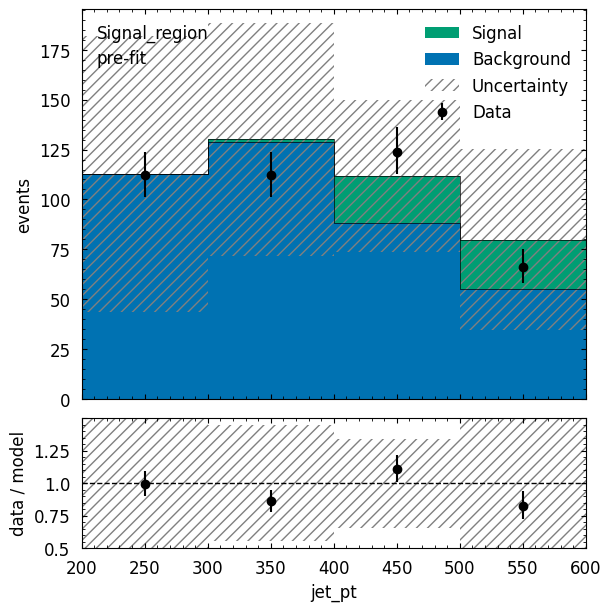

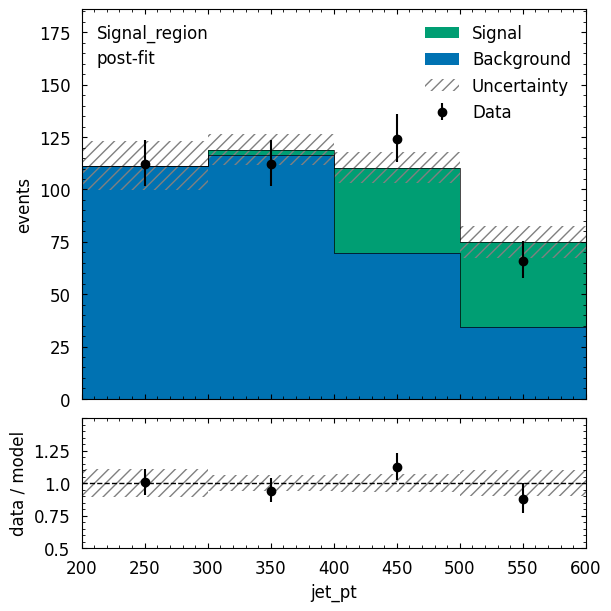

In [4]:
# visualize the pre-fit model prediction and data
prediction_prefit = cabinetry.model_utils.prediction(model)
cabinetry.visualize.data_mc(prediction_prefit, data, config=config)

# visualize the post-fit model prediction and data
prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
cabinetry.visualize.data_mc(prediction_postfit, data, config=config)

Check what the nuisance parameter pulls look like

INFO - cabinetry.visualize.utils - saving figure as simple_pulls/pulls.pdf


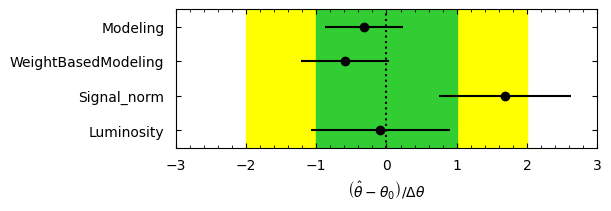

In [5]:
cabinetry.visualize.pulls(
    fit_results, close_figure=True, save_figure=True, figure_folder="simple_pulls/"
)

Now we want to run our ranking computations, and we have a choice of which method to use via the `impacts_method` argument in `cabinetry.fit.ranking`

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.35                      │              Nfcn = 269              │
│ EDM = 2.69e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────

CPU times: user 816 ms, sys: 26.2 ms, total: 842 ms
Wall time: 896 ms


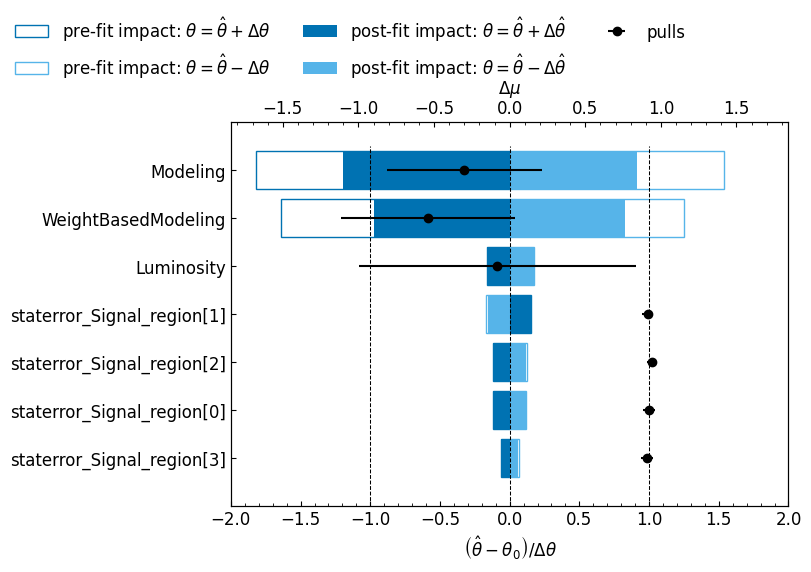

In [6]:
%%time
# Run ranking with the NP-shifting method
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, impacts_method="np_shift")
cabinetry.visualize.ranking(ranking_results, close_figure=True, save_figure=True, figure_folder="simple_rankings/")

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - calculating impact of WeightBasedModeling on Signal_norm
INFO - cabinetry.fit - calculating impact of Luminosity on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[0] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[1] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[2] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[3] on Signal_norm
INFO - cabinetry.visualize.utils - saving figure as simple_rankings/ranking_covariance.pdf


CPU times: user 151 ms, sys: 13.9 ms, total: 165 ms
Wall time: 191 ms


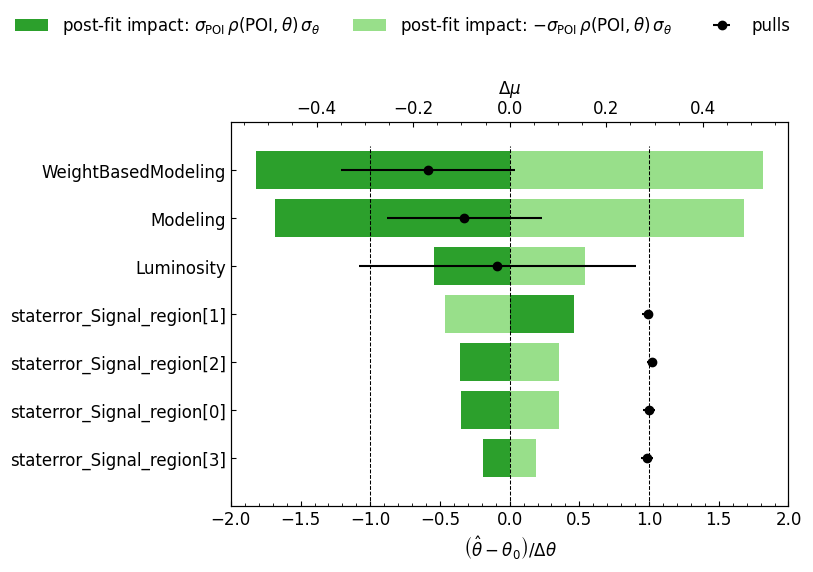

In [7]:
%%time
# Run ranking with covariance-based method: this is the default method
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, impacts_method="covariance")
cabinetry.visualize.ranking(ranking_results, close_figure=True, save_figure=True, figure_folder="simple_rankings/")

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.58                      │              Nfcn = 291              │
│ EDM = 4.85e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────

CPU times: user 524 ms, sys: 15 ms, total: 539 ms
Wall time: 541 ms


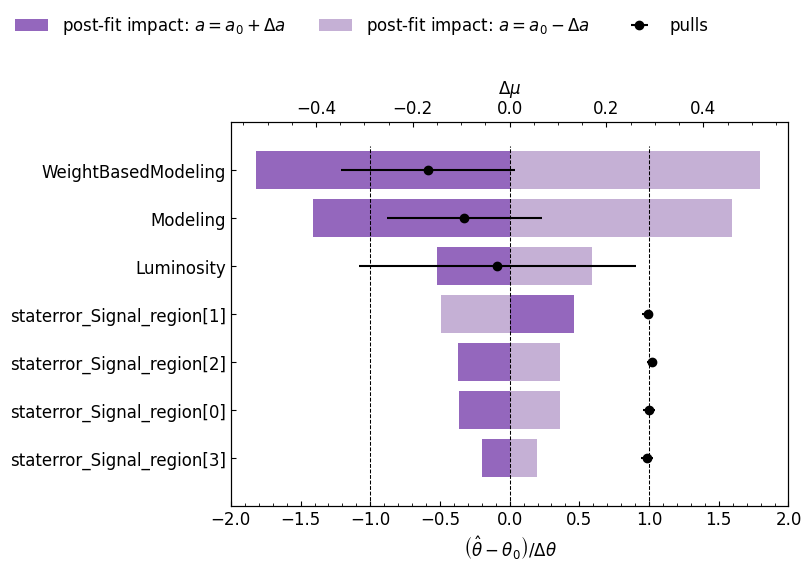

In [8]:
%%time
# Run ranking with covariance-based method: this is the default method
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, impacts_method="auxdata_shift")
cabinetry.visualize.ranking(ranking_results, close_figure=True, save_figure=True, figure_folder="simple_rankings/")

<h3 style="color:green;">Distributed ranking computation </h3>

Ranking is very computationally intensive in the NP-shifting and Auxiliary data-shifting methods. For this simple configuration, we don't feel it, but for larger models (e.g. 100 of parameters), the single-fit time increases, the number of fits required explodes, a ranking can take days to run sequentially.

Current `cabinetry` implementation of the ranking function does not allow for any form of parallelisation without the user having to re-write elements of the function themselves.
In this next part of the notebook, we demonstrate that there is now: 
- an infrastructure for the user to parallelise calls to the ranking function (4 fits at a time (NP) or 2 fits at a time (AUX))
- an API to get a maximal distribution of individual ranking fits on a cluster via a `dask` client

To run this part, `dask.distributed` is needed in the environment. You should run
```
pip install dask[distributed]
``` 

Note that, in production, `dask` will be an optional dependency in `cabinetry`

<h4 style="color:green;"> Set up dask client </h4>

In [9]:
import time
from dask.distributed import Client, LocalCluster, PipInstall
from cabinetry.fit import utils

COFFEA_CASA = False
client, cluster = None, None
def get_client(n_workers):
    if not COFFEA_CASA:
        # clocal setup
        cluster = LocalCluster(n_workers=n_workers, processes=True, threads_per_worker=1)
        client = Client(cluster)
        print(f"Dask dashboard: {cluster.dashboard_link}")
    else:
        #coffea-casa setup
        # We need to install the custom version of cabinetry on the workers,
        # since they only inherit the base image state
        dependencies = [
            "git+https://github.com/MoAly98/cabinetry.git@maly-issue-442",
        ]
        client = Client("tls://localhost:8786")
        # register the pip installation of the custom cabinetry version
        client.register_plugin(PipInstall(packages=dependencies))
    return cluster, client

def dead_client(cluster, client):
    client.close()
    cluster.close()
    return None, None

<h4 style="color:green;"> Parallelising ranking calls </h4>

The ranking function now accepts a list of parameters for which the ranking should be computed. This option can be used to call the ranking function for one parameter at-a-time, and evaluate them in parallel on a cluster.

In [10]:
# Write the function that returns the workload to be distributed
# calls to this function are collected then distributed to the workers
# the use of a wrapper function is to handle dask serliazation issues with
# the pyhf model object, fit_results object and numpy arrays --> is there a better way to write this?
def  get_ranking_function(param, model_spec, data, fit_results_serialisable, method="auxdata_shift"):
    fit_results_int = cabinetry.model_utils.FitResults(**fit_results_serialisable)
    workspace = pyhf.Workspace(model_spec)
    model_int = workspace.model(
    modifier_settings={
        "normsys": {"interpcode": "code4"},
        "histosys": {"interpcode": "code4p"},
        }
    )

    ranking_result = cabinetry.fit.ranking(model_int, data, fit_results=fit_results_int,
                                                impacts_method=method, parameters_list=[param])
    return ranking_result

In [11]:
fit_results_serialisable = {
    "bestfit": fit_results.bestfit.tolist(),
    "uncertainty": fit_results.uncertainty.tolist(),
    "labels": list(fit_results.labels),
    "corr_mat": fit_results.corr_mat.tolist(),
    "best_twice_nll": float(fit_results.best_twice_nll),
}

# get the list of model parameters
parameters_list = model.config.par_names

def run_dask(func, client):
    try:
        # collect dask futures, which are calls to the ranking function
        futures = [
                client.submit(func, param, ws, data, fit_results_serialisable)
                for param in parameters_list
            ]
        # gathering the results actually starts the computation on the cluster
        individual_ranking_results = client.gather(futures)
        return individual_ranking_results
    except Exception as e:
        cluster, client = dead_client(cluster, client)
        raise e

In [12]:
if client is not None:
    %time individual_ranking_results = run_dask(get_ranking_function, client)
    cluster, client = dead_client(cluster, client)
else:
    for idx in range(4):
        idx += 1
        cluster, client = get_client(n_workers=idx)
        start = time.time()
        individual_ranking_results = run_dask(get_ranking_function, client)
        end = time.time()
        print(f"Elapsed for {idx} workers: {end - start:.2f} seconds")
        cluster, client = dead_client(cluster, client)

Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 1 workers: 1.27 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 2 workers: 0.94 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 3 workers: 0.89 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 4 workers: 0.81 seconds


Now that we  have the results from individual ranking calls, we need to combine them and plot! We implemented a utility to allow a user to do this combination quickly and pass the result to plotting functions

INFO - cabinetry.visualize.utils - saving figure as simple_dask_rankings/ranking_auxdata_shift.pdf


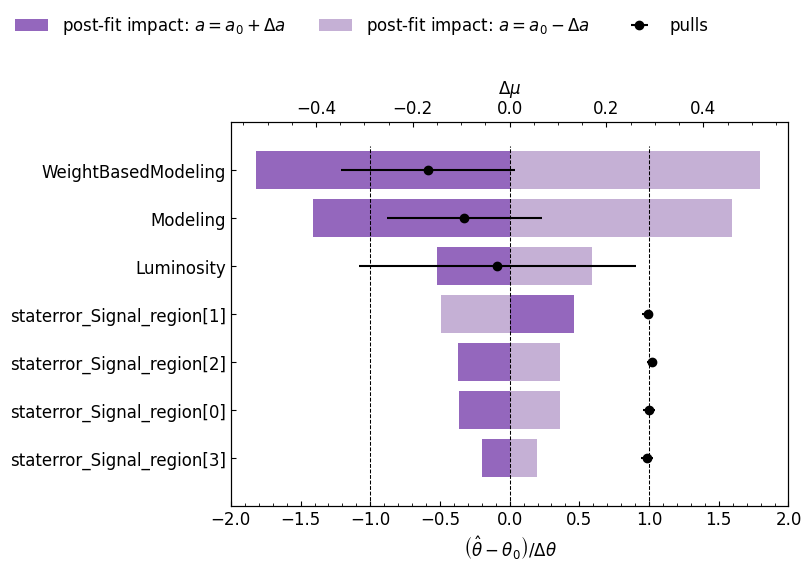

In [13]:
ranking_results = utils.collect_ranking_results(individual_ranking_results)
cabinetry.visualize.ranking(
    ranking_results, close_figure=True, save_figure=True, figure_folder="simple_dask_rankings", max_pars=10
)

The fit is too fast right now to see the benefit given the `dask` overhead, so let's add some delay to see the difference between the serial and distirbuted code

In [14]:
def  get_delayed_ranking_function(param, model_spec, data, fit_results_serialisable, method="auxdata_shift", delay_by=0):
    fit_results_int = cabinetry.model_utils.FitResults(**fit_results_serialisable)
    workspace = pyhf.Workspace(model_spec)
    model_int = workspace.model(
    modifier_settings={
        "normsys": {"interpcode": "code4"},
        "histosys": {"interpcode": "code4p"},
        }
    )
    time.sleep(delay_by)
    return cabinetry.fit.ranking(model_int, data, fit_results=fit_results_int,
                                                impacts_method=method, parameters_list=[param])

if client is not None:
    %time individual_ranking_results = run_dask(get_delayed_ranking_function, client)
    cluster, client = dead_client(cluster, client)
else:
    for idx in range(4):
        idx += 1
        cluster, client = get_client(n_workers=idx)
        start = time.time()
        individual_ranking_results = run_dask(get_delayed_ranking_function, client)
        end = time.time()
        print(f"Elapsed for {idx} workers: {end - start:.2f} seconds")
        cluster, client = dead_client(cluster, client)

Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 1 workers: 1.13 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 2 workers: 0.90 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 3 workers: 0.85 seconds
Dask dashboard: http://127.0.0.1:8787/status
Elapsed for 4 workers: 0.81 seconds


INFO - cabinetry.visualize.utils - saving figure as simple_dask_rankings_delayed/ranking_auxdata_shift.pdf


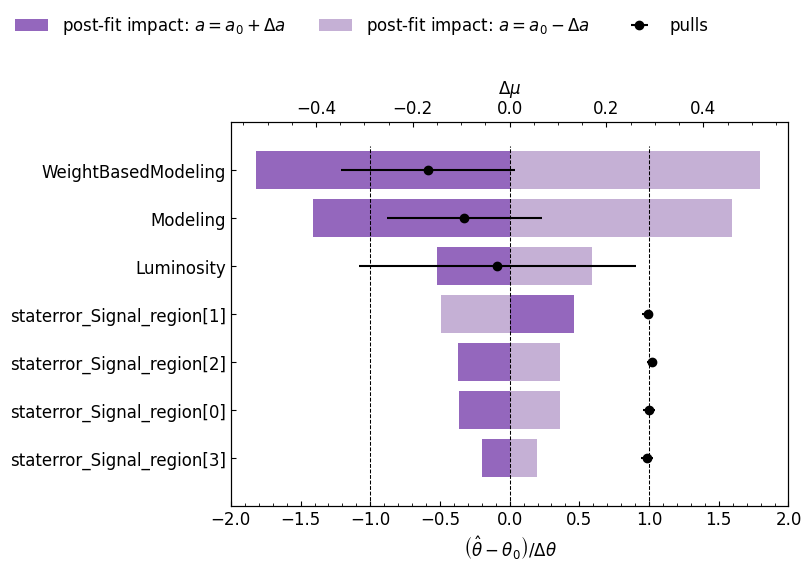

In [15]:
ranking_results = utils.collect_ranking_results(individual_ranking_results)
cabinetry.visualize.ranking(
    ranking_results, close_figure=True, save_figure=True, figure_folder="simple_dask_rankings_delayed", max_pars=10
)

<h4 style="color:green;"> Parallelising fit calls </h4>

The user can instead choose to let cabinetry handle the parallelisation for them by passing a dask client to the ranking funciton call. Behind the scenes, cabinetry will collect individual calls to the **fit** function, and then submit them to the cluster through the client

In [ ]:
def delayed_ranking():
     time.sleep(5)
     ranking_result_auxdata_shift = cabinetry.fit.ranking(model, data, fit_results=fit_results,
                                                impacts_method="auxdata_shift", parameters_list=parameters_list, client=client)

    return ranking_result_auxdata_shift
try:
    if client is not None:
        ranking_result_auxdata_shift = cabinetry.fit.ranking(model, data, fit_results=fit_results,
                                                impacts_method="auxdata_shift", parameters_list=parameters_list, client=client)
        cluster, client = dead_client(cluster, client)
    else:
        cluster, client = get_client(n_workers=4)
        ranking_result_auxdata_shift = cabinetry.fit.ranking(model, data, fit_results=fit_results,
                                                impacts_method="auxdata_shift", parameters_list=parameters_list, client=client)
        cluster, client = dead_client(cluster, client)
except Exception as e:
        cluster, client = dead_client(cluster, client)
        raise e

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - calculating impact of WeightBasedModeling on Signal_norm
INFO - cabinetry.fit - calculating impact of Luminosity on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[0] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[1] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[2] on Signal_norm
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[3] on Signal_norm


Dask dashboard: http://127.0.0.1:8787/status


INFO - cabinetry.visualize.utils - saving figure as simple_dask_rankings_dist_fit/ranking_auxdata_shift.pdf


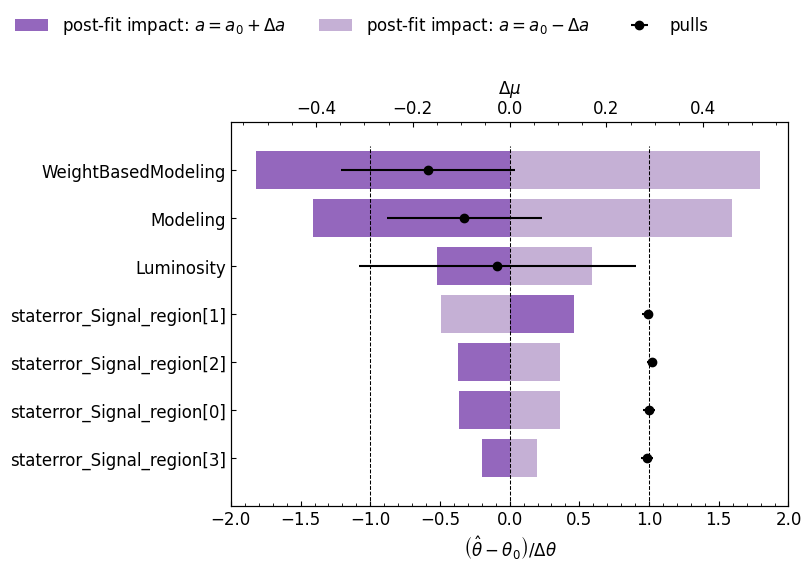

In [24]:
cabinetry.visualize.ranking(
    ranking_result_auxdata_shift, close_figure=True, save_figure=True, figure_folder="simple_dask_rankings_dist_fit", max_pars=10
)